In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import numpy as np
import sys
import os
sys.path.append("../")
from search_world.utils.analysis_utils import get_trials_dataframe, get_dataset_paths, get_trials_features, get_consistency, get_condition_df, get_condition_features
from search_world.utils.moog_utils import get_trial_paths, get_trial_dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import pandas as pd
from matplotlib import cm
from search_world.utils.plot_utils import plot_maze
%matplotlib inline

Loading in agent data

In [114]:
base_dir = '../logs'

all_job_ids = [f for f in os.scandir(base_dir) if f.is_dir() and f.path != os.path.join(base_dir,'slurm_logs')]
agent_df = get_trials_dataframe(get_dataset_paths(job_ids=all_job_ids, base_dir=''), overwrite=False)
# condition_df = get_condition_features(get_condition_df(df, condition=['length', 'n_corr', 'agent_init_state', 'target_state']), df)
# consistency_df = get_consistency(condition_df, df, condition=['length', 'n_corr', 'agent_init_state', 'target_state'])

Loading in human data

In [115]:
human_base_dir = '../human_logs'
dataset_paths = [f.path for f in os.scandir(human_base_dir)]

dataset_trial_paths = []
for i, path in enumerate(dataset_paths): 
    trial_paths = get_trial_paths(path)
    dataset_trial_paths.append(trial_paths)
    
dataset_index = 0
trial_df = []
for trial_paths in dataset_trial_paths:
    if len(trial_paths) > 0:
        dataset_index += 1

        new_df =  get_trial_dataframe(trial_paths, dataset_index=dataset_index)
        trial_df.append(new_df)

trial_df = pd.concat(trial_df)
# human_df = get_trials_features(trial_df)
# human_df = human_df[agent_df.columns]
print('Total number of trials: %d' % len(trial_df))

Number of trials:  182
Number of trials:  42
Number of trials:  18
Number of trials:  20
Number of trials:  7
Number of trials:  3
Number of trials:  204
Number of trials:  4
Number of trials:  51
Number of trials:  19
Number of trials:  0
Number of trials:  93
Number of trials:  164
Number of trials:  5
Number of trials:  95
Number of trials:  2
Number of trials:  201
Number of trials:  54
Number of trials:  66
Number of trials:  3
Number of trials:  43
Number of trials:  12
Number of trials:  2
Number of trials:  205
Number of trials:  53
Number of trials:  0
Number of trials:  13
Number of trials:  61
Number of trials:  24
Number of trials:  1
Number of trials:  5
Number of trials:  56
Number of trials:  39
Number of trials:  4
Number of trials:  0
Number of trials:  6
Number of trials:  87
Number of trials:  2
Number of trials:  2
Number of trials:  3
Number of trials:  308
Number of trials:  33
Number of trials:  72
Number of trials:  3
Number of trials:  31
Number of trials:  7
N

Concatenating human and agent data into a single dataframe, find consistency scores

In [130]:
df = pd.concat((agent_df, trial_df))
df = get_trials_features(df)
# df = df[df.n_corr.isin((3, 4)) & df.length.isin((7, 9))]

In [131]:
condition_df = get_condition_features(get_condition_df(df, condition=['length', 'n_corr', 'agent_init_state', 'target_state']), df)
consistency_df = get_consistency(condition_df, df, condition=['length', 'n_corr', 'agent_init_state', 'target_state'])

/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [132]:
consistency_df_norm = consistency_df.copy().to_numpy()
for a_1 in np.arange(len(consistency_df.columns)):
    for a_2 in np.arange(len(consistency_df.columns)):
        if a_1 != a_2:
            consistency_df_norm[a_1, a_2] = consistency_df_norm[a_1, a_2]/np.sqrt((np.diag(consistency_df_norm)[a_1] * np.diag(consistency_df_norm)[a_2]))

consistency_df_norm = pd.DataFrame(consistency_df_norm, columns=consistency_df.columns)
consistency_df_norm

name,Human,MLSAgent,QMDPAgent
0,0.516410,0.257760,0.243589
1,0.257760,0.957725,0.218392
2,0.243589,0.218392,0.977572


# Condition counts across agents

In [91]:
%matplotlib inline
# condition_count = df.groupby(['length', 'n_corr', 'name'])['trial_index'].count().to_frame().reset_index().rename(columns={'trial_index':'trial_count'})
# g = sns.catplot(x="length", y="trial_count",
#                 hue="n_corr", col="name",
#                 data=condition_count, kind="bar",
#                 height=4, aspect=.7, sharey=False)
# plt.show()

Number of conditions: 382


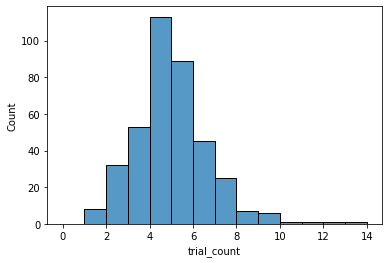

In [127]:
%matplotlib inline 
condition_count = df.groupby(['length', 'n_corr', 'agent_init_state', 'target_state', 'name'])['trial_index'].count().to_frame().reset_index().rename(columns={'trial_index':'trial_count'})
condition_count = condition_count[condition_count.n_corr.isin((3, 4)) & condition_count.length.isin((7, 9)) & condition_count.name.eq('Human')]
print('Number of conditions: %d' % len(condition_count))
sns.histplot(condition_count.trial_count, bins=np.arange(condition_count.trial_count.max()+1))
plt.show()

In [107]:
len(condition_count[condition_count.trial_count < 4][['length', 'n_corr', 'agent_init_state', 'target_state']].to_records(index=False))

138

In [58]:
%matplotlib inline 
# condition_count = df.groupby(['length', 'n_corr', 'agent_init_state', 'target_state', 'name'])['trial_index'].count().to_frame().reset_index().rename(columns={'trial_index':'trial_count'})
# condition_count = condition_count[condition_count.n_corr.isin((3, 4)) & condition_count.length.isin((7, 9))]
# g = sns.catplot(x="length", y="trial_count",
#                 hue="target_state", col="name", row='n_corr',
#                 data=condition_count, kind="strip",
#                 height=4, aspect=.7, sharey=False)
# plt.show()

# Consistency across agents

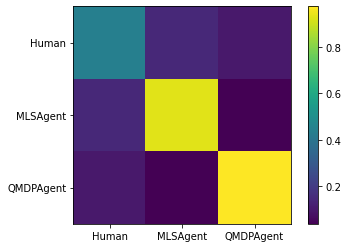

In [128]:
%matplotlib inline
f, ax = plt.subplots(1, 1)
im = ax.imshow(consistency_df)

ax.set_xticks(np.arange(len(consistency_df.columns)))
ax.set_yticks(np.arange(len(consistency_df.columns)))
ax.set_xticklabels(consistency_df.columns)
ax.set_yticklabels(consistency_df.columns)
plt.colorbar(im)
plt.show()

## Normalized consistency

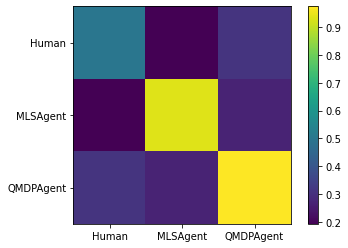

name,Human,MLSAgent,QMDPAgent
0,0.499969,0.192916,0.311245
1,0.192916,0.935739,0.271011
2,0.311245,0.271011,0.974633


In [103]:
%matplotlib inline
f, ax = plt.subplots(1, 1)
im = ax.imshow(consistency_df_norm)            
ax.set_xticks(np.arange(len(consistency_df.columns)))
ax.set_yticks(np.arange(len(consistency_df.columns)))
ax.set_xticklabels(consistency_df.columns)
ax.set_yticklabels(consistency_df.columns)
plt.colorbar(im)
plt.show()
consistency_df_norm

In [59]:
condition = condition_df.index.names[:-1]

## MLS-QMDP

In [108]:
%matplotlib widget
mls_df = condition_df[condition_df.index.get_level_values('name') == 'MLSAgent'].reset_index().set_index(condition)
qmdp_df = condition_df[condition_df.index.get_level_values('name') == 'QMDPAgent'].reset_index().set_index(condition)
optimal_df = condition_df[condition_df.index.get_level_values('name') == 'OptimalAgent'].reset_index().set_index(condition)
merged = mls_df.merge(qmdp_df, on=condition, suffixes=['_mls', '_qmdp']).dropna()
conditions = merged.index
f, ax = plt.subplots(1, 1)
f.suptitle('MLS-QMDP consistency')
sc = sns.scatterplot(data=merged, x="error_mls", y="error_qmdp", ax=ax)

cursor = mplcursors.cursor(sc, hover=True)
# # by default the annotation displays the xy positions
# # this is to change it to the countries name
@cursor.connect("add")
def on_add(sel):
#     sel.annotation.set(text="length=%d, n_corr=%d, agent_init_pos=%d, target_pos=%d"%(conditions[sel.index]))
    sel.annotation.set(text=(conditions[sel.index]))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [62]:
cond = (9, 4, 9, 3) 
condition_df.loc[cond].error 

name
Human           0.012121
MLSAgent        0.017677
OptimalAgent    0.000000
QMDPAgent       0.017957
Name: error, dtype: float64

name                                                        MLSAgent
agent_dist                          [36, 23, 21, 13, 30, 22, 11, 41]
agent_dist_hist    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
error                                                      0.0176768
n_trials                                                           8
Name: (9, 4, 9, 3), dtype: object
name                                                       QMDPAgent
agent_dist         [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
agent_dist_hist    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
error                                                              0
n_trials                                                          25
Name: (9, 4, 9, 3), dtype: object


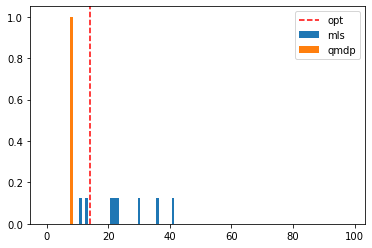

In [109]:
%matplotlib inline
cond = (9, 4, 9, 3)
print(mls_df.loc[cond])
print(qmdp_df.loc[cond])
# print(optimal_df.loc[cond])
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), mls_df.loc[cond].agent_dist_hist, label='mls')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), qmdp_df.loc[cond].agent_dist_hist, label='qmdp')
plt.axvline(x=np.where(optimal_df.loc[cond].agent_dist_hist)[0][0], color='r', linestyle='--', label='opt')
# plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), optimal_df.loc[cond].agent_dist_hist, label='opt')
plt.legend()
plt.show()

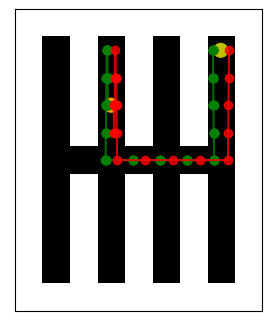

In [64]:
f, ax = plt.subplots(1,1, dpi=100)
other = df[df['name'] == 'MLSAgent'].set_index(condition).sort_index().loc[cond].iloc[2].discrete_agent_states
plot_maze(df[df['name'] == 'Human'].set_index(condition).sort_index().loc[cond].iloc[0],ax=ax, other=other)

# MLS-Human

In [110]:
%matplotlib widget
condition
mls_df = condition_df[condition_df.index.get_level_values('name') == 'MLSAgent'].reset_index().set_index(condition)
human_df = condition_df[condition_df.index.get_level_values('name') == 'Human'].reset_index().set_index(condition)
merged = mls_df.merge(human_df, on=condition, suffixes=['_mls', '_human']).dropna()
conditions = merged.index
f, ax = plt.subplots(1, 1)
f.suptitle('MLS-Human consistency')
sc = sns.scatterplot(data=merged, x="error_mls", y="error_human", ax=ax, hue='length')

cursor = mplcursors.cursor(sc, hover=True)
# # by default the annotation displays the xy positions
# # this is to change it to the countries name
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=(conditions[sel.index]))

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyError: (5, 3, 6, 3)

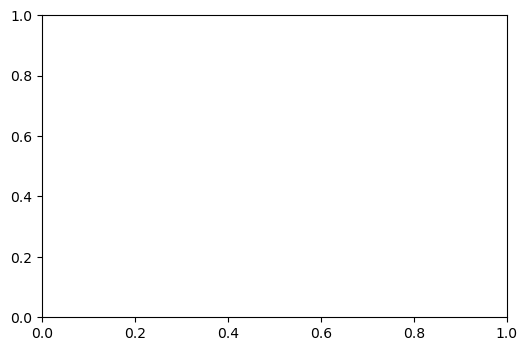

In [66]:
%matplotlib inline
cond = (5, 3, 6, 3)
# print(mls_df.loc[cond])
# print(qmdp_df.loc[cond])
# print(optimal_df.loc[cond])
f, ax = plt.subplots(1, 1, dpi=100)
plt.axvline(x=np.where(optimal_df.loc[cond].agent_dist_hist)[0][0], color='k', linestyle='--', label='opt')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), mls_df.loc[cond].agent_dist_hist, label='mls')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), qmdp_df.loc[cond].agent_dist_hist, label='qmdp')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), human_df.loc[cond].agent_dist_hist, label='human')
# plt.hist(mls_df.loc[cond].agent_dist, label='mls', density=True)
# plt.hist(qmdp_df.loc[cond].agent_dist, label='qmdp', density=True)
# plt.hist(human_df.loc[cond].agent_dist, label='human', density=True)

# plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), optimal_df.loc[cond].agent_dist_hist, label='opt')
plt.xlabel('Number of steps')
plt.ylabel('Frac. of trials')
plt.legend()
plt.show()
f, ax = plt.subplots(1,1, dpi=100)
other = df[df['name'] == 'MLSAgent'].set_index(condition).sort_index().loc[cond].iloc[2].discrete_agent_states
plot_maze(df[df['name'] == 'Human'].set_index(condition).sort_index().loc[cond].iloc[0],ax=ax, other=other)

# QMDP-Human

In [111]:
%matplotlib widget
condition
qmdp_df = condition_df[condition_df.index.get_level_values('name') == 'QMDPAgent'].reset_index().set_index(condition)
human_df = condition_df[condition_df.index.get_level_values('name') == 'Human'].reset_index().set_index(condition)
merged = qmdp_df.merge(human_df, on=condition, suffixes=['_qmdp', '_human']).dropna()
conditions = merged.index
f, ax = plt.subplots(1, 1)
f.suptitle('QMDP-Human consistency')
sc = sns.scatterplot(data=merged, x="error_qmdp", y="error_human", hue='length', ax=ax)

cursor = mplcursors.cursor(sc, hover=True) 

@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=(conditions[sel.index]))

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

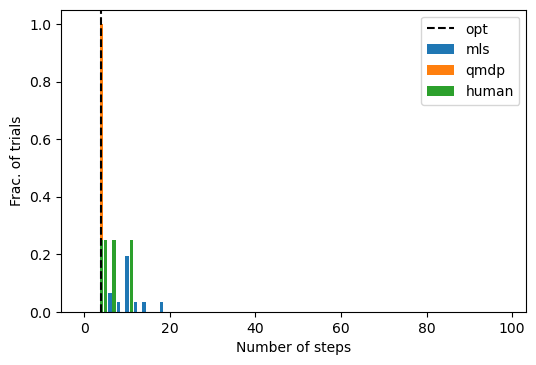

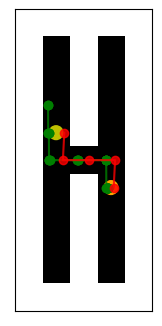

In [231]:
%matplotlib inline
cond = (9, 2, 12, 6)
# print(mls_df.loc[cond])
# print(qmdp_df.loc[cond])
# print(optimal_df.loc[cond])
f, ax = plt.subplots(1, 1, dpi=100)
plt.axvline(x=np.where(optimal_df.loc[cond].agent_dist_hist)[0][0], color='k', linestyle='--', label='opt')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), mls_df.loc[cond].agent_dist_hist, label='mls')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), qmdp_df.loc[cond].agent_dist_hist, label='qmdp')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), human_df.loc[cond].agent_dist_hist, label='human')
# plt.hist(mls_df.loc[cond].agent_dist, label='mls', density=True)
# plt.hist(qmdp_df.loc[cond].agent_dist, label='qmdp', density=True)
# plt.hist(human_df.loc[cond].agent_dist, label='human', density=True)

# plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), optimal_df.loc[cond].agent_dist_hist, label='opt')
plt.xlabel('Number of steps')
plt.ylabel('Frac. of trials')
plt.legend()
plt.show()
f, ax = plt.subplots(1,1, dpi=100)
other = df[df['name'] == 'QMDPAgent'].set_index(condition).sort_index().loc[cond].iloc[2].discrete_agent_states
plot_maze(df[df['name'] == 'Human'].set_index(condition).sort_index().loc[cond].iloc[0],ax=ax, other=other)

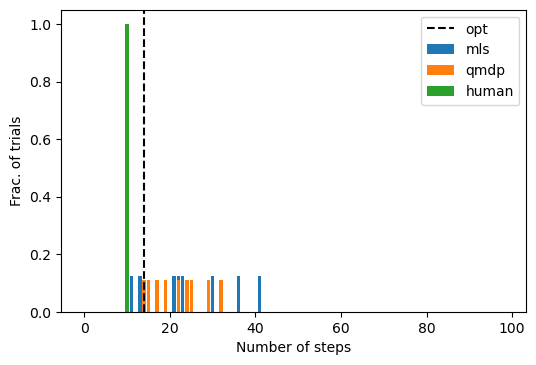

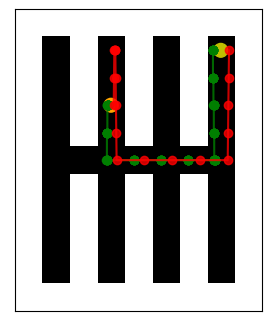

In [232]:
%matplotlib inline
cond = (9, 4, 9, 3)
# print(mls_df.loc[cond])
# print(qmdp_df.loc[cond])
# print(optimal_df.loc[cond])
f, ax = plt.subplots(1, 1, dpi=100)
plt.axvline(x=np.where(optimal_df.loc[cond].agent_dist_hist)[0][0], color='k', linestyle='--', label='opt')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), mls_df.loc[cond].agent_dist_hist, label='mls')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), qmdp_df.loc[cond].agent_dist_hist, label='qmdp')
plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), human_df.loc[cond].agent_dist_hist, label='human')
# plt.hist(mls_df.loc[cond].agent_dist, label='mls', density=True)
# plt.hist(qmdp_df.loc[cond].agent_dist, label='qmdp', density=True)
# plt.hist(human_df.loc[cond].agent_dist, label='human', density=True)

# plt.bar(np.arange(len(mls_df.loc[cond].agent_dist_hist)), optimal_df.loc[cond].agent_dist_hist, label='opt')
plt.xlabel('Number of steps')
plt.ylabel('Frac. of trials')
plt.legend()
plt.show()
f, ax = plt.subplots(1,1, dpi=100)
other = df[df['name'] == 'QMDPAgent'].set_index(condition).sort_index().loc[cond].iloc[2].discrete_agent_states
plot_maze(df[df['name'] == 'Human'].set_index(condition).sort_index().loc[cond].iloc[0],ax=ax, other=other)